[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1AIIpyzAzbO9DkitSj0v-xcZr1MzfCJxk#scrollTo=N1m3EZy_ASX7)

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# архитектура модели
# гиперпараметры хз
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [3]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)


In [5]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [6]:
dataset_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

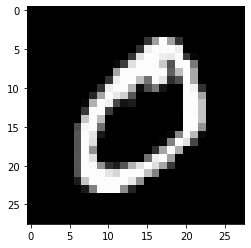

In [7]:
plt.imshow(dataset_train.data[1].detach().numpy(), cmap='gray')
plt.show()

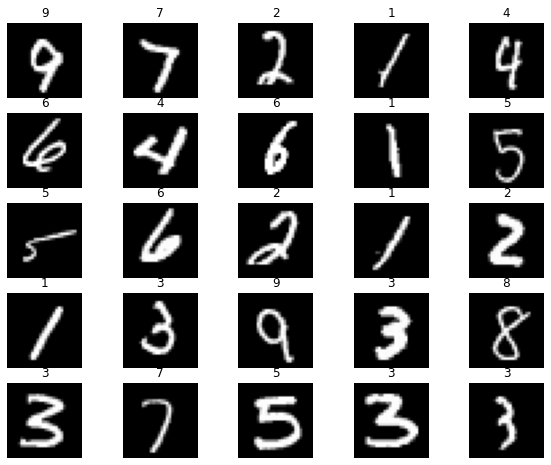

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
 sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
 img, label = dataset_train[sample_idx]
 figure.add_subplot(rows, cols, i)
 plt.title(label)
 plt.axis("off")
 plt.imshow(img.squeeze(), cmap="gray")
plt.show()

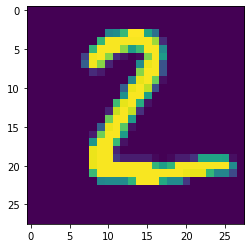

In [9]:
plt.imshow(dataset_test.data[1].detach().numpy())
plt.show()

In [10]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x


In [11]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset_train = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [12]:
dataloader_train = DataLoader(dataset_train, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [13]:
dataset_test = datasets.MNIST('.', train=False, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [14]:
# 60000 // 128 # число шагов

In [15]:
dataloader_test = DataLoader(dataset_test, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [16]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [17]:
for epoch in range(n_epochs):
    # train model
    model.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model.eval()
    for i, batch in enumerate(dataloader_test):
              inputs, labels = batch
              loss_test = 0
              with torch.no_grad():
                  predict = model(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', (loss_test / i).item())
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.2950518131256104
epoch: 0, step: 200, loss: 0.4209306836128235
epoch: 0, step: 400, loss: 0.26143142580986023
test loss: 0.001286863349378109
epoch: 1, step: 0, loss: 0.2554314136505127
epoch: 1, step: 200, loss: 0.13041773438453674
epoch: 1, step: 400, loss: 0.20799800753593445
test loss: 0.0012991076800972223
epoch: 2, step: 0, loss: 0.18404771387577057
epoch: 2, step: 200, loss: 0.0778319463133812
epoch: 2, step: 400, loss: 0.06613459438085556
test loss: 0.002299292478710413
epoch: 3, step: 0, loss: 0.046931635588407516
epoch: 3, step: 200, loss: 0.08140448480844498
epoch: 3, step: 400, loss: 0.08405480533838272
test loss: 0.0008321258355863392
epoch: 4, step: 0, loss: 0.03722434490919113
epoch: 4, step: 200, loss: 0.07033985108137131
epoch: 4, step: 400, loss: 0.07242145389318466
test loss: 0.0013627681182697415
epoch: 5, step: 0, loss: 0.05018352344632149
epoch: 5, step: 200, loss: 0.06965628266334534
epoch: 5, step: 400, loss: 0.034115057438611984
test 

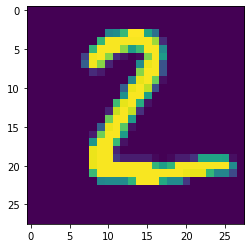

predict: 2
true:    2


In [23]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [24]:
class LinearModel1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.do = nn.Dropout(dropout_p)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, X):
        X = self.act(self.do(self.linear1(X)))
        X = self.act(self.do(self.linear2(X)))
        X = self.linear3(X)

        return X
     

In [25]:
model1 = LinearModel1(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model1.parameters())
loss_func = nn.CrossEntropyLoss()

In [26]:
for epoch in range(n_epochs):
    # train model
    model1.train()
    for i, batch in enumerate(dataloader_train):
        optim.zero_grad()

        predict = model1(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

    # test model
    model1.eval()
    for i, batch in enumerate(dataloader_test):
              inputs, labels = batch
              loss_test = 0
              with torch.no_grad():
                  predict = model1(batch['data'].to(device))
                  loss_test += loss_func(predict, batch['target'].to(device))
    print('test loss:', loss_test.item() / i)
    
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.3051815032958984
epoch: 0, step: 200, loss: 0.2803748846054077
epoch: 0, step: 400, loss: 0.2743872106075287
test loss: 0.0026199763471429997
epoch: 1, step: 0, loss: 0.15690453350543976
epoch: 1, step: 200, loss: 0.17537635564804077
epoch: 1, step: 400, loss: 0.13879479467868805
test loss: 0.00184239408412537
epoch: 2, step: 0, loss: 0.1648796945810318
epoch: 2, step: 200, loss: 0.09234881401062012
epoch: 2, step: 400, loss: 0.09939730912446976
test loss: 0.00050290838464514
epoch: 3, step: 0, loss: 0.02940853126347065
epoch: 3, step: 200, loss: 0.042392317205667496
epoch: 3, step: 400, loss: 0.057367220520973206
test loss: 0.0007222987130864874
epoch: 4, step: 0, loss: 0.09682762622833252
epoch: 4, step: 200, loss: 0.04085709899663925
epoch: 4, step: 400, loss: 0.06753995269536972
test loss: 0.0002619450210363834
epoch: 5, step: 0, loss: 0.03158815577626228
epoch: 5, step: 200, loss: 0.07954244315624237
epoch: 5, step: 400, loss: 0.05142262205481529
test lo

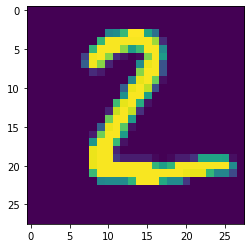

predict: 2
true:    2


In [27]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float()
target = dataset_test.targets[i].tolist()
model1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model1(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

# Новый раздел

In [28]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [36]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.conv(x))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv3 = ConvDO(hidden_ch, 1, 3, 1, 1)
        self.linear = nn.Linear(
            14 * 14, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)

In [54]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [39]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [40]:
for epoch in range(n_epochs):
    #train model
    model_conv.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test.item() / i)
    
    #save every epoch
    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.299341917037964
epoch: 0, step: 200, loss: 0.3623107969760895
epoch: 0, step: 400, loss: 0.20531463623046875
test loss: 0.0012792886851669906
epoch: 1, step: 0, loss: 0.23179233074188232
epoch: 1, step: 200, loss: 0.15101712942123413
epoch: 1, step: 400, loss: 0.134701207280159
test loss: 0.0010247731750661676
epoch: 2, step: 0, loss: 0.11935223639011383
epoch: 2, step: 200, loss: 0.11328291893005371
epoch: 2, step: 400, loss: 0.2677420377731323
test loss: 0.0003350547623711747
epoch: 3, step: 0, loss: 0.07327435910701752
epoch: 3, step: 200, loss: 0.010206591337919235
epoch: 3, step: 400, loss: 0.12533138692378998
test loss: 0.00010041723197156733
epoch: 4, step: 0, loss: 0.08591607958078384
epoch: 4, step: 200, loss: 0.04278070107102394
epoch: 4, step: 400, loss: 0.05372181162238121
test loss: 0.0004142991134098598
epoch: 5, step: 0, loss: 0.054502010345458984
epoch: 5, step: 200, loss: 0.05705513432621956
epoch: 5, step: 400, loss: 0.092888742685318
test l

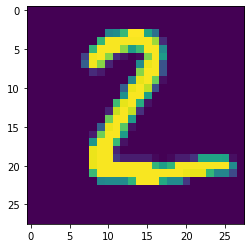

predict: 2
true:    2


In [41]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i].tolist()
model_conv.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

In [78]:
class ConvDO1(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):
                
        return self.do(self.conv(x))

class ConvModel1(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO1(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза 14x14
        self.pool = nn.MaxPool2d(kernel_size=2) # TODO еще уменьшить размер фичматрицы 7x7
        self.conv2 = ConvDO1(hidden_ch, hidden_ch, 3, 1, 1)
        self.conv3 = ConvDO1(hidden_ch, 10, 3, 1, 1) # TODO увеличить число выходных каналов
        self.linear1 = nn.Linear(
            10 * 7 * 7, # TODO поправить при изменении числа каналов и размера фич матриц
            200
        )  
        self.linear2 = nn.Linear(200, output_dim)
        self.activ = nn.ReLU()    
        self.bn = nn.BatchNorm2d(hidden_ch) # TODO добавить батч норм

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.pool(x)
        x = self.activ(self.conv2(x))
        x = self.bn(x)
        x = self.activ(self.conv3(x))
        x = self.linear1(x.view(x.size(0), -1))
        x = self.activ(x)
        x = self.linear2(x)
        
        return x

In [79]:
model_conv1 = ConvModel1(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv1.parameters())
loss_func = nn.CrossEntropyLoss()

In [80]:
for epoch in range(n_epochs):
    #train model
    model_conv1.train()
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv1(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    #test model
    model_conv1.eval()
    for i, batch in enumerate(testloader):
        inputs, labels = batch
        loss_test = 0
        with torch.no_grad():
            predict = model_conv1(inputs.to(device))
            loss_test += loss_func(predict, labels.to(device))
    
    print('test loss:', loss_test / i)
    
    #save every epoch
    torch.save(model_conv1.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')

epoch: 0, step: 0, loss: 2.306469678878784
epoch: 0, step: 200, loss: 0.12510241568088531
epoch: 0, step: 400, loss: 0.03323045372962952
test loss: tensor(0.0006, device='cuda:0')
epoch: 1, step: 0, loss: 0.010270568542182446
epoch: 1, step: 200, loss: 0.12511050701141357
epoch: 1, step: 400, loss: 0.028220295906066895
test loss: tensor(0.0003, device='cuda:0')
epoch: 2, step: 0, loss: 0.020596882328391075
epoch: 2, step: 200, loss: 0.025189820677042007
epoch: 2, step: 400, loss: 0.030268028378486633
test loss: tensor(0.0005, device='cuda:0')
epoch: 3, step: 0, loss: 0.018917307257652283
epoch: 3, step: 200, loss: 0.03527561575174332
epoch: 3, step: 400, loss: 0.04959625005722046
test loss: tensor(2.1124e-05, device='cuda:0')
epoch: 4, step: 0, loss: 0.0008210803498513997
epoch: 4, step: 200, loss: 0.03917946666479111
epoch: 4, step: 400, loss: 0.025455111637711525
test loss: tensor(6.6135e-05, device='cuda:0')
epoch: 5, step: 0, loss: 0.00556565448641777
epoch: 5, step: 200, loss: 0.0

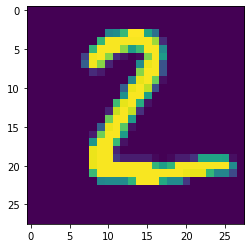

predict: 2
true:    2


In [96]:
i=1
image = dataset_test.data[i].detach().numpy()
data = dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float()
target = dataset_test.targets[i]
model_conv1.eval()
plt.imshow(image)
plt.show()
predict = torch.argmax(model_conv1(data)).squeeze().detach()
print(f"predict: {predict}")
print(f"true:    {target}")

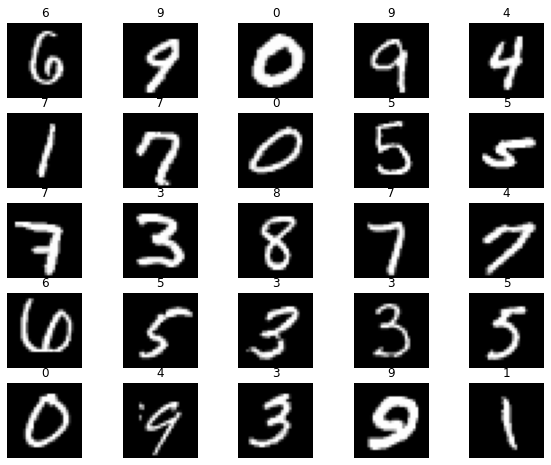

In [102]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
 sample_idx = torch.randint(len(dataset_test), size=(1,)).item()
 img, label = dataset_test[sample_idx]
 data = dataset_test.data[sample_idx].unsqueeze(0).unsqueeze(0).to(device).float()
 predict = torch.argmax(model_conv1(data)).squeeze().detach().item()
 figure.add_subplot(rows, cols, i)
 plt.title(predict)
 plt.axis("off")
 plt.imshow(img.squeeze(), cmap="gray")
plt.show()